# SUMMARIZATION: There are two ways to summarize a document 
### i. By passing full document
### ii. Using Map-Reduce for larger sets of document. This splits the documents into batches summarizes those, and then summarizes the summaries.

In [1]:
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [9]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [10]:
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [11]:
llm = ChatGoogleGenerativeAI(model = 'gemini-1.5-flash')

In [12]:
llm.invoke("Hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e49b515f-8e0c-42d9-9b4e-9c9dc77b243e-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [13]:
# loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
loader = WebBaseLoader("https://www.totalhealthandfitness.com/what-is-mindful-eating-your-complete-guide-to-enjoying-your-food-more/")
docs = loader.load()

In [14]:
docs

[Document(metadata={'source': 'https://www.totalhealthandfitness.com/what-is-mindful-eating-your-complete-guide-to-enjoying-your-food-more/', 'title': 'What is Mindful Eating? Your Complete Guide to Enjoying Your Food More | Total Health and Fitness', 'description': 'Explore what mindful eating is in this complete guide, offering principles, benefits, and tips to savor food and enhance well-being. Free consultation!', 'language': 'en-US'}, page_content='\n\n\n\n\n\n\n\n\n\n\nWhat is Mindful Eating? Your Complete Guide to Enjoying Your Food More | Total Health and Fitness\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n\n\nCALL (801) 572-8050 Login\nToggle NavigationOur ProgramsNutritionExerciseAccountabilityCorporate WellnessOnline ServicesSuccess StoriesAbout UsLocationTeamResourcesFAQVideosOur AppsBlogShopContactBook Client AppointmentBook Client AppointmentToggle NavigationOur ProgramsNutritionExerciseAcco

In [15]:
from langchain_core.prompts import ChatPromptTemplate
# prompt = ChatPromptTemplate.from_messages(
#     [("system","Write a concise summary of the following:{context}")]
# )
prompt = ChatPromptTemplate.from_template("Write a concise summary of the following: {context}")

In [16]:
from langchain.chains.combine_documents import create_stuff_documents_chain
chain = create_stuff_documents_chain(llm,prompt)

In [17]:
result = chain.invoke({"context":docs})

In [18]:
from pprint import pprint
pprint(result)

('Mindful eating is a practice of fully engaging with the experience of '
 'eating, paying attention to tastes, textures, and body cues of hunger and '
 'fullness.  It differs from dieting by focusing on the quality of the eating '
 'experience rather than restriction. Benefits include improved digestion, '
 'better emotional eating management, weight management, and increased overall '
 'well-being.  The practice involves creating a relaxing environment, '
 "listening to your body's hunger cues, eating slowly, and savoring each "
 'bite.  A step-by-step guide is provided, along with strategies for '
 'overcoming challenges like emotional eating.')


In [19]:
llm.invoke("Hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-125bbb69-2578-4ff7-8c67-cfdbde4a54bc-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

### II Methods using map reduce

In [20]:
# from langchain import hub
# llm = ChatGoogleGenerativeAI(model = "gemini-1.5-flash-8b",google_api_key = GOOGLE_API_KEY)

from langchain_groq import ChatGroq
llm = ChatGroq(model='gemma2-9b-it')

In [21]:
llm.invoke("Hi")

AIMessage(content='Hi! 👋 How can I help you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 10, 'total_tokens': 23, 'completion_time': 0.023636364, 'prompt_time': 4.1e-07, 'queue_time': 0.021294936, 'total_time': 0.023636774}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d3f61455-7180-4425-a9d1-20c6b0180469-0', usage_metadata={'input_tokens': 10, 'output_tokens': 13, 'total_tokens': 23})

In [22]:
map_prompt = ChatPromptTemplate.from_template("Write a concise summary of the following: {context}")

In [23]:
reduce_template = """The following is a set of summaries:{docs}
Take these and distill it into a final, consolidated summary of the main themes."""

reduce_prompt = ChatPromptTemplate.from_template(reduce_template)

In [24]:
from langchain_text_splitters import CharacterTextSplitter

In [148]:
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
# loader = WebBaseLoader("https://www.totalhealthandfitness.com/what-is-mindful-eating-your-complete-guide-to-enjoying-your-food-more/")
docs = loader.load()

In [150]:
text_splitter = CharacterTextSplitter(chunk_size = 4000,chunk_overlap = 0)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents")

Created a chunk of size 4145, which is longer than the specified 4000


Generated 14 documents


In [151]:
import operator
from typing import Annotated,List, Literal, TypedDict

# acollapse -> Asynchronously collapses multiple documents into a single summary
# split list of docs -> split list of docs into smaller chunks
from langchain.chains.combine_documents.reduce import acollapse_docs, split_list_of_docs
# SEND -> send is used in langgraph to define message passing behaviour between nodes.
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
token_max = 1000

In [212]:
def length_function(documents:List[Document]) ->int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)

In [213]:
class OverallState(TypedDict):
    contents: List[str]
    summaries: Annotated[list,operator.add]
    collapsed_summaries: List[Document]
    final_summary: str

In [214]:
class SummaryState(TypedDict):
    content: str

In [215]:
async def generate_summary(state:SummaryState):
    prompt = map_prompt.invoke(state['content'])
    response = await llm.ainvoke(prompt)
    return {"summaries":[response.content]}


In [216]:
def map_summaries(state:OverallState):
    return [
        Send("generate_summary",{"content":content}) for content in state["contents"]
    ]

In [217]:
# def collect_summaries(state:OverallState):
#     return {
#         "collapsed_summaries":[Document(summary) for summary in state["summaries"]]
#     }
def collect_summaries(state: OverallState):
    print("DEBUG: Inside collect_summaries")
    print("DEBUG: Summaries received ->", state["summaries"])
    print("DEBUG: Type of summaries ->", type(state["summaries"]))

    # Ensure summaries is a list of strings
    if not isinstance(state["summaries"], list):
        raise TypeError(f"Expected list for summaries, got {type(state['summaries'])}")

    if any(not isinstance(summary, str) for summary in state["summaries"]):
        raise TypeError(f"Summaries contains non-string elements: {state['summaries']}")

    output = {"collapsed_summaries": [Document(summary) for summary in state["summaries"]]}
    print("DEBUG: Length of summaries->",len(state["summaries"]))
    print("DEBUG: Output from collect_summaries ->", output)
    return output



In [218]:
# async def _reduce(input:dict) -> str:
#     prompt = reduce_prompt.invoke(input)
#     response = await llm.ainvoke(prompt)
#     return response.content
async def _reduce(input):
    print("DEBUG: Input to _reduce:", input)  # Debugging print

    # Check input format
    if isinstance(input, list):
        input = " ".join([doc.page_content if isinstance(doc, Document) else str(doc) for doc in input])
    elif isinstance(input, dict):
        input = " ".join([str(v) for v in input.values()])

    print("DEBUG: Processed input to _reduce:", input)  # Debugging print

    # Now pass the properly formatted text to LLM
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    print("DEBUG: Type of output->",type(response.content))
    return response.content


In [219]:
# async def collapse_summaries(state:OverallState):
#     doc_lists = split_list_of_docs(
#         state["collapsed_summaries"],length_function,token_max
#     )

#     results = []
#     for doc_list in doc_lists:
#         reduced_summary = await acollapse_docs(doc_list,_reduce)
#         results.append(Document(reduced_summary))

#     return {"collapsed_summaries":results}
async def collapse_summaries(state: OverallState):
    print("DEBUG: Input to collapse_summaries:", state["collapsed_summaries"])  # Debugging print

    # Check if collapsed_summaries is empty or not a list
    if not state["collapsed_summaries"]:
        raise ValueError("ERROR: collapse_summaries received an empty list!")

    if not all(isinstance(doc, Document) for doc in state["collapsed_summaries"]):
        raise TypeError(f"ERROR: Expected list of Document objects, got {state['collapsed_summaries']}")

    doc_lists = split_list_of_docs(state["collapsed_summaries"], length_function, token_max)
    print("DEBUG: Split Documents into batches:", doc_lists)  # Debugging print

    results = []
    for doc_list in doc_lists:
        reduced_summary = await acollapse_docs(doc_list, _reduce)

        # Ensure reduced_summary is a string before creating Document
        # if not isinstance(reduced_summary, str):
        #     raise TypeError(f"ERROR: Expected string from _reduce, got {type(reduced_summary)}")

        results.append(reduced_summary)

    print("DEBUG: Results after collapsing:", results)  # Debugging print
    return {"collapsed_summaries": results}



In [220]:
# def should_collapse(state:OverallState) -> Literal["collapse_summaries","generate_final_summary"]:
#     num_tokens = length_function(state["collapsed_summaries"])
#     if num_tokens>token_max:
#         return "collapse_summaries"
#     else:
#         return "generate_final_summary"
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    print("DEBUG: Before Token Count in should_collapse")
    num_tokens = length_function(state["collapsed_summaries"])
    
    print("DEBUG: Token Count in should_collapse:", num_tokens)  # Debugging print
    
    if num_tokens > token_max:
        print("DEBUG: Deciding to collapse summaries")
        return "collapse_summaries"
    else:
        print("DEBUG: Skipping collapse, going to generate_final_summary")
        return "generate_final_summary"


In [221]:
async def generate_final_summary(state:OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary":response}

In [222]:
graph = StateGraph(OverallState)
graph.add_node("generate_summary",generate_summary)
graph.add_node("collect_summaries",collect_summaries)
graph.add_node("collapse_summaries",collapse_summaries)
graph.add_node("generate_final_summary",generate_final_summary)

graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary","collect_summaries")
graph.add_conditional_edges("collect_summaries",should_collapse)
graph.add_conditional_edges("collapse_summaries",should_collapse)
graph.add_edge("generate_final_summary",END)

app = graph.compile()


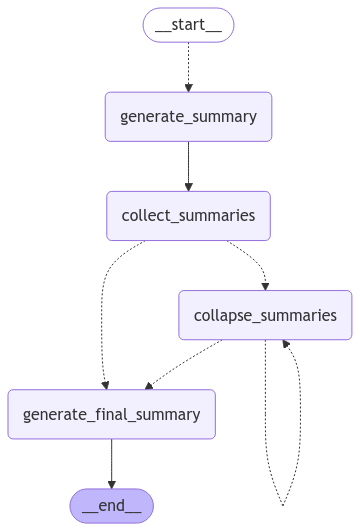

In [223]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [224]:
async for step in app.astream(
    {"contents":[doc.page_content for doc in split_docs]},
    {"recursion_limit":10}
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
DEBUG: Inside collect_summaries
DEBUG: Summaries received -> ['This article explores the concept of LLM-powered autonomous agents, showcasing their potential as powerful problem solvers beyond text generation. \n\nIt outlines three key components of these agent systems:\n\n* **Planning:** Agents break down complex tasks into smaller, manageable subgoals and reflect on past actions to refine their approach.\n* **Memory:**  Agents utilize both short-term memory (in-context learning) and long-term memory (external vector stores) to retain and recall information.\n* **Tool Use:** Agents leverage external APIs to access real-time data, execute code, and utilize proprietary information sources, expandin

In [225]:
print(step)

{'generate_final_summary': {'final_summary': 'These texts explore the rapid development of Large Language Models (LLMs) towards becoming autonomous agents capable of complex problem-solving.  \n\nKey themes highlight both the exciting potential and the ongoing challenges:\n\n* **Towards Autonomy:** LLMs are being equipped with capabilities like planning, memory, and tool-use, enabling them to act more independently. However,  challenges remain in areas like long-term memory, robust planning, and accurate natural language understanding.\n* **The Art of Prompting:**  Effective communication with LLMs is crucial, requiring careful "prompt engineering" to guide their actions and ensure they understand complex goals. \n* **Expanding Capabilities:** Research focuses on integrating LLMs with external tools and APIs, expanding their functionality and applicability to real-world tasks.\n* **Ethical Considerations:**  The increasing autonomy of LLMs raises ethical concerns, particularly regardin